In [18]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/wikipedia-structured-contents/enwiki_namespace_0/enwiki_namespace_0_31.jsonl
/kaggle/input/wikipedia-structured-contents/enwiki_namespace_0/enwiki_namespace_0_26.jsonl
/kaggle/input/wikipedia-structured-contents/enwiki_namespace_0/enwiki_namespace_0_35.jsonl
/kaggle/input/wikipedia-structured-contents/enwiki_namespace_0/enwiki_namespace_0_14.jsonl
/kaggle/input/wikipedia-structured-contents/enwiki_namespace_0/enwiki_namespace_0_2.jsonl
/kaggle/input/wikipedia-structured-contents/enwiki_namespace_0/enwiki_namespace_0_21.jsonl
/kaggle/input/wikipedia-structured-contents/enwiki_namespace_0/enwiki_namespace_0_34.jsonl
/kaggle/input/wikipedia-structured-contents/enwiki_namespace_0/enwiki_namespace_0_10.jsonl
/kaggle/input/wikipedia-structured-contents/enwiki_namespace_0/enwiki_namespace_0_22.jsonl
/kaggle/input/wikipedia-structured-contents/enwiki_namespace_0/enwiki_namespace_0_20.jsonl
/kaggle/input/wikipedia-structured-contents/enwiki_namespace_0/enwiki_namespace_0_32.jsonl


In [19]:
# reservoir_sample_wiki.py
import os, json, random, csv
from pathlib import Path
from tqdm.auto import tqdm

In [20]:

# PARAMETERS
INPUT_ROOT = "/kaggle/input"   # adjust to your dataset path if needed
JSONL_PREFIX = "enwiki_namespace_0_"  # prefix to match files
K = 500  # set to 300..500 per your needs
OUT_JSONL = f"/kaggle/working/sample_by_keys_{K}.jsonl"
OUT_METACSV = f"/kaggle/working/sample_by_keys_{K}_meta.csv"

In [21]:
def find_jsonl_files(root, prefix):
    files = []
    for r, _, names in os.walk(root):
        for n in names:
            if n.startswith(prefix) and n.endswith(".jsonl"):
                files.append(os.path.join(r, n))
    return sorted(files)

In [22]:
def extract_fields(obj):
    """
    Extract only fields that exist in this object.
    Returns a dict with selected keys (may be empty strings if not present).
    """
    # id
    page_id = obj.get("identifier") or obj.get("id") or obj.get("page_id") or None

    # title/name
    title = obj.get("name") or obj.get("title") or obj.get("page_title") or None

    # abstract or snippet: prefer 'abstract', then 'sections' first paragraph, then 'description'
    abstract = ""
    if "abstract" in obj and obj.get("abstract"):
        abstract = obj.get("abstract")
    else:
        # try sections: find first paragraph-like text
        sections = obj.get("sections") or obj.get("has_parts") or None
        if isinstance(sections, list) and len(sections) > 0:
            # scan for first paragraph value in sections structure
            for sec in sections:
                parts = sec.get("has_parts") if isinstance(sec, dict) else None
                if isinstance(parts, list):
                    for part in parts:
                        # paragraph type parts
                        if part.get("type") == "paragraph" and part.get("value"):
                            abstract = part.get("value")
                            break
                        # some dumps store paragraph directly as {'value': '...'}
                        if part.get("value") and isinstance(part.get("value"), str):
                            abstract = part.get("value")
                            break
                # if we found it, break
                if abstract:
                    break
    # fallback to 'description'
    if not abstract:
        abstract = obj.get("description") or obj.get("summary") or ""

    # image url (if available)
    image_url = ""
    if "image" in obj and isinstance(obj["image"], dict):
        image_url = obj["image"].get("content_url") or ""
    # try infobox images
    if not image_url and isinstance(obj.get("infoboxes"), list):
        for inf in obj["infoboxes"]:
            # inf may contain parts with images
            parts = inf.get("has_parts") or []
            for part in parts:
                if part.get("type") == "image":
                    imgs = part.get("images") or []
                    if imgs and isinstance(imgs, list):
                        first = imgs[0]
                        image_url = first.get("content_url") or ""
                        if image_url:
                            break
                # nested check
            if image_url:
                break

    # license info (if present)
    license_info = ""
    lic = obj.get("license") or obj.get("licenses") or None
    if lic:
        # license may be list of dicts
        if isinstance(lic, list) and len(lic) > 0:
            # join names/identifiers
            license_info = ";".join([ (l.get("identifier") or l.get("name") or str(l)) for l in lic ])
        elif isinstance(lic, dict):
            license_info = lic.get("identifier") or lic.get("name") or str(lic)

    # url
    url = obj.get("url") or obj.get("source") or ""

    # build final small record
    small = {
        "id": page_id,
        "title": title,
        "abstract": abstract.replace("\n", " ").strip() if isinstance(abstract, str) else "",
        "image_url": image_url,
        "license": license_info,
        "url": url
    }
    return small

def sample_until_k(files, k, out_jsonl, out_metacsv):
    collected = 0
    seen_ids = set()
    with open(out_jsonl, "w", encoding="utf-8") as outj, \
         open(out_metacsv, "w", newline='', encoding="utf-8") as outcsv:
        writer = csv.DictWriter(outcsv, fieldnames=["id","title","abstract","image_url","license","url","source_file"])
        writer.writeheader()
        for path in files:
            print("Scanning:", Path(path).name)
            with open(path, "r", encoding="utf-8") as fh:
                for line in tqdm(fh, desc=Path(path).name):
                    try:
                        obj = json.loads(line)
                    except Exception:
                        continue
                    small = extract_fields(obj)
                    # require at least a title or abstract to accept (you can relax if desired)
                    if not small["title"] and not small["abstract"]:
                        continue
                    unique = small["id"] or small["title"]
                    if unique and unique in seen_ids:
                        continue
                    # write to outputs
                    meta_row = small.copy()
                    meta_row["source_file"] = os.path.basename(path)
                    writer.writerow(meta_row)
                    outj.write(json.dumps(small, ensure_ascii=False) + "\n")
                    collected += 1
                    if unique:
                        seen_ids.add(unique)
                    if collected >= k:
                        print(f"Collected {collected} docs; stopping.")
                        return collected
    print(f"Finished scanning files. Collected {collected} docs.")
    return collected

# ---- run ----
files = find_jsonl_files(INPUT_ROOT, JSONL_PREFIX)
print("Found files:", files[:8], " (showing up to 8)")

collected = sample_until_k(files, K, OUT_JSONL, OUT_METACSV)
print("Done. Collected:", collected)

Found files: ['/kaggle/input/wikipedia-structured-contents/enwiki_namespace_0/enwiki_namespace_0_0.jsonl', '/kaggle/input/wikipedia-structured-contents/enwiki_namespace_0/enwiki_namespace_0_1.jsonl', '/kaggle/input/wikipedia-structured-contents/enwiki_namespace_0/enwiki_namespace_0_10.jsonl', '/kaggle/input/wikipedia-structured-contents/enwiki_namespace_0/enwiki_namespace_0_11.jsonl', '/kaggle/input/wikipedia-structured-contents/enwiki_namespace_0/enwiki_namespace_0_12.jsonl', '/kaggle/input/wikipedia-structured-contents/enwiki_namespace_0/enwiki_namespace_0_13.jsonl', '/kaggle/input/wikipedia-structured-contents/enwiki_namespace_0/enwiki_namespace_0_14.jsonl', '/kaggle/input/wikipedia-structured-contents/enwiki_namespace_0/enwiki_namespace_0_15.jsonl']  (showing up to 8)
Scanning: enwiki_namespace_0_0.jsonl


enwiki_namespace_0_0.jsonl: 0it [00:00, ?it/s]

Collected 500 docs; stopping.
Done. Collected: 500


In [23]:
# run in a Kaggle notebook cell
# Install core libs we need for chunking + embeddings + plotting (no dependency upgrades)
!pip install -q --no-deps sentence-transformers tiktoken matplotlib seaborn scikit-learn nltk langchain


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


In [24]:
# (Run once) NLTK downloads for simple tokenization/pos if needed
import nltk
nltk.download('punkt')


[nltk_data] Downloading package punkt to /usr/share/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [25]:

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# LangChain and token splitter
from langchain.text_splitter import TokenTextSplitter, RecursiveCharacterTextSplitter

# SentenceTransformers for embeddings
from sentence_transformers import SentenceTransformer
from sklearn.metrics.pairwise import cosine_similarity

# simple tokenizer
from nltk.tokenize import word_tokenize

In [26]:
# CONFIG
SAMPLE_JSONL = "/kaggle/working/sample_by_keys_500.jsonl"  # change path to your sample file (300..500)
K = 500  # documents in sample
EMBED_MODEL = "all-MiniLM-L6-v2"  # free, small & fast
BATCH_SIZE = 64
OUTPUT_DIR = "/kaggle/working/raglens_outputs"
os.makedirs(OUTPUT_DIR, exist_ok=True)

In [27]:
import os

print(os.listdir("/kaggle/working"))


['.virtual_documents', 'sample_by_keys_500_meta.csv', 'raglens_outputs', 'sample_by_keys_500.jsonl']


In [28]:
# Load sample jsonl created earlier
docs = []
with open(SAMPLE_JSONL, "r", encoding="utf-8") as fh:
    for line in fh:
        obj = json.loads(line)
        # Expect fields: id, title, abstract (snippet) - fallback to abstract or title
        text = obj.get("abstract") or obj.get("description") or ""
        if not text:
            # if only title exists, skip (we want text)
            continue
        docs.append({
            "id": obj.get("id") or obj.get("title"),
            "title": obj.get("title"),
            "text": text,
            "meta": obj
        })
len(docs)


500

In [29]:
# TokenTextSplitter: precise token counts
splitters = {
    "tok_300": TokenTextSplitter(chunk_size=300, chunk_overlap=50, encoding_name="cl100k_base"),
    "tok_500": TokenTextSplitter(chunk_size=500, chunk_overlap=80, encoding_name="cl100k_base"),
    "tok_1000": TokenTextSplitter(chunk_size=1000, chunk_overlap=150, encoding_name="cl100k_base"),
}

# Char-based fallback (approx tokens -> chars) if you prefer RecursiveCharacterTextSplitter:
char_est = 4  # rough average chars per token
char_splitters = {
    "char_300": RecursiveCharacterTextSplitter(chunk_size=300*char_est, chunk_overlap=int(300*char_est*0.15)),
    "char_500": RecursiveCharacterTextSplitter(chunk_size=500*char_est, chunk_overlap=int(500*char_est*0.15)),
    "char_1000": RecursiveCharacterTextSplitter(chunk_size=1000*char_est, chunk_overlap=int(1000*char_est*0.15)),
}


In [30]:
def chunk_document(text, splitter):
    # splitter: langchain splitter with split_text method
    chunks = splitter.split_text(text)
    # return list of dicts with chunk text and token/char length estimates
    return [{"text": c, "char_len": len(c), "word_len": len(word_tokenize(c))} for c in chunks]


In [31]:
from collections import defaultdict, OrderedDict

all_chunks = {}  # structure: {strategy: [{doc_id, title, chunk_id, text, char_len, word_len}, ...]}
for name, splitter in splitters.items():
    rows = []
    for doc in tqdm(docs, desc=f"chunking {name}"):
        chunks = chunk_document(doc["text"], splitter)
        for i, c in enumerate(chunks):
            rows.append({
                "doc_id": doc["id"],
                "title": doc["title"],
                "chunk_id": i,
                "chunk_text": c["text"],
                "char_len": c["char_len"],
                "word_len": c["word_len"]
            })
    all_chunks[name] = pd.DataFrame(rows)
    # save chunk csv
    all_chunks[name].to_csv(os.path.join(OUTPUT_DIR, f"chunks_{name}.csv"), index=False)
    print(name, "chunks:", len(all_chunks[name]))


chunking tok_300:   0%|          | 0/500 [00:00<?, ?it/s]

tok_300 chunks: 521


chunking tok_500:   0%|          | 0/500 [00:00<?, ?it/s]

tok_500 chunks: 504


chunking tok_1000:   0%|          | 0/500 [00:00<?, ?it/s]

tok_1000 chunks: 500


In [32]:
model = SentenceTransformer(EMBED_MODEL)

def embed_texts(texts):
    embeds = []
    for i in range(0, len(texts), BATCH_SIZE):
        batch = texts[i:i+BATCH_SIZE]
        e = model.encode(batch, show_progress_bar=False, convert_to_numpy=True)
        embeds.append(e)
    return np.vstack(embeds)

# compute and store embeddings for each strategy
embeddings_store = {}
for name, df in all_chunks.items():
    texts = df["chunk_text"].tolist()
    if len(texts)==0:
        embeddings_store[name] = np.empty((0, model.get_sentence_embedding_dimension()))
        continue
    embs = embed_texts(texts)
    embeddings_store[name] = embs
    np.save(os.path.join(OUTPUT_DIR, f"embeddings_{name}.npy"), embs)
    print(name, "-> embeddings shape", embs.shape)


tok_300 -> embeddings shape (521, 384)
tok_500 -> embeddings shape (504, 384)
tok_1000 -> embeddings shape (500, 384)


In [34]:
from tqdm.auto import tqdm
from sklearn.feature_extraction.text import TfidfVectorizer

def tokenize_lower(text):
    toks = [t.lower() for t in word_tokenize(text) if t.isalpha()]
    return toks

def jaccard_ratio(a,b):
    sa = set(a); sb=set(b)
    if not sa or not sb: return 0.0
    return len(sa & sb) / len(sa | sb)

# Full doc embedding (we'll compute per doc once)
doc_full_embeds = {}
for doc in tqdm(docs, desc="full doc embeddings"):
    doc_full_embeds[doc["id"]] = model.encode(doc["text"], convert_to_numpy=True)

# scorer per strategy
quality_scores = {}  # strategy -> dataframe of doc-level metrics
for name, df in all_chunks.items():
    docs_group = []
    for doc_id, group in df.groupby("doc_id"):
        chunks_texts = group["chunk_text"].tolist()
        if len(chunks_texts)==0:
            continue
        # overlap ratio
        toks = [tokenize_lower(t) for t in chunks_texts]
        overlaps = []
        for i in range(len(toks)-1):
            overlaps.append(jaccard_ratio(toks[i], toks[i+1]))
        overlap_ratio = np.mean(overlaps) if overlaps else 0.0
        # semantic completeness: chunk -> full doc similarity
        chunk_embs = model.encode(chunks_texts, convert_to_numpy=True)
        full_emb = doc_full_embeds.get(doc_id)
        if full_emb is None:
            full_emb = model.encode(" ".join(chunks_texts), convert_to_numpy=True)
        sims_to_full = cosine_similarity(chunk_embs, full_emb.reshape(1,-1)).flatten()
        semantic_completeness = np.mean(sims_to_full)
        # density: lexical diversity average across chunks
        densities = []
        for t in toks:
            if len(t)==0:
                densities.append(0.0)
            else:
                densities.append(len(set(t))/len(t))
        density_of_meaning = np.mean(densities)
        # redundancy: mean pairwise chunk similarity
        if len(chunk_embs)>1:
            sims = cosine_similarity(chunk_embs)
            # take upper triangle excluding diagonal
            iu = np.triu_indices_from(sims, k=1)
            redundancy = np.mean(sims[iu]) if iu[0].size>0 else 0.0
        else:
            redundancy = 0.0

        docs_group.append({
            "doc_id": doc_id,
            "n_chunks": len(chunks_texts),
            "overlap_ratio": float(overlap_ratio),
            "semantic_completeness": float(semantic_completeness),
            "density_of_meaning": float(density_of_meaning),
            "redundancy": float(redundancy)
        })
    quality_scores[name] = pd.DataFrame(docs_group)
    quality_scores[name].to_csv(os.path.join(OUTPUT_DIR, f"quality_scores_{name}.csv"), index=False)
    print(f"{name} -> scored {len(docs_group)} docs")


full doc embeddings:   0%|          | 0/500 [00:00<?, ?it/s]

tok_300 -> scored 500 docs
tok_500 -> scored 500 docs
tok_1000 -> scored 500 docs


In [35]:
# combine summary
rows=[]
for name, qdf in quality_scores.items():
    if qdf.empty: continue
    rows.append({
        "strategy": name,
        "avg_chunks": qdf["n_chunks"].mean(),
        "avg_overlap": qdf["overlap_ratio"].mean(),
        "avg_semantic_completeness": qdf["semantic_completeness"].mean(),
        "avg_density": qdf["density_of_meaning"].mean(),
        "avg_redundancy": qdf["redundancy"].mean()
    })
summary_df = pd.DataFrame(rows)
summary_df.to_csv(os.path.join(OUTPUT_DIR, "chunking_summary.csv"), index=False)
summary_df


,strategy,avg_chunks,avg_overlap,avg_semantic_completeness,avg_density,avg_redundancy
0,tok_300,1.042,0.008847,0.992361,0.771504,0.019466
1,tok_500,1.008,0.001735,0.998660,0.767843,0.005320
2,tok_1000,1.000,0.000000,1.000000,0.767164,0.000000


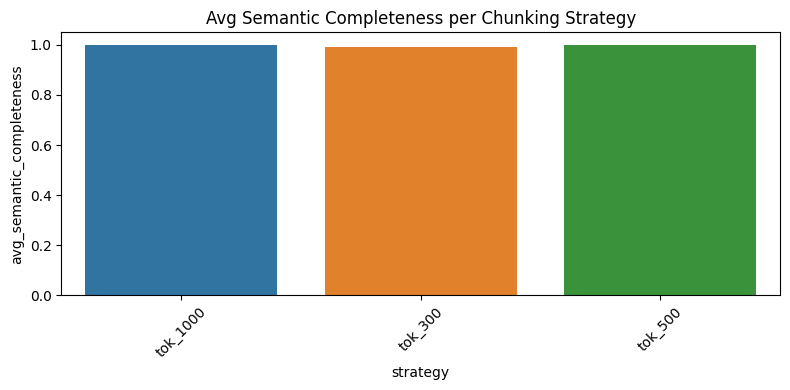

In [36]:
plt.figure(figsize=(8,4))
sns.barplot(data=summary_df.sort_values("strategy"), x="strategy", y="avg_semantic_completeness")
plt.title("Avg Semantic Completeness per Chunking Strategy")
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig(os.path.join(OUTPUT_DIR,"avg_semantic_completeness.png"), dpi=200)
plt.show()


In [37]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics.pairwise import cosine_similarity
from scipy.cluster.hierarchy import linkage, leaves_list


In [38]:
def plot_doc_chunk_heatmap(chunks_df, embeddings, doc_id, max_chunks=None, cmap="viridis", savepath=None):
    """
    chunks_df: DataFrame with doc_id and chunk ordering (must match embeddings order).
    embeddings: numpy array, shape (n_chunks_total, emb_dim), same order as chunks_df rows.
    doc_id: identifier of doc to visualize
    max_chunks: if doc has many chunks, optionally limit to first N
    """
    # select indices for this doc
    idx = chunks_df.index[chunks_df["doc_id"] == doc_id].tolist()
    if not idx:
        print("doc_id not found:", doc_id); return
    if max_chunks:
        idx = idx[:max_chunks]
    embs = embeddings[idx]
    if embs.shape[0] < 2:
        print("Not enough chunks to plot (need >=2). Got:", embs.shape[0]); return

    # cosine similarity
    sim = cosine_similarity(embs)  # shape (n_chunks, n_chunks)

    # optional hierarchical ordering (keeps natural order by chunk_id unless reordering desired)
    try:
        # reorder using hierarchical clustering so blocks are visible (comment out to keep chunk order)
        Z = linkage(1 - sim, method="average")  # cluster on distance = 1 - similarity
        order = leaves_list(Z)
        sim = sim[np.ix_(order, order)]
        labels = [f"c{chunks_df.loc[idx[i],'chunk_id']}" for i in order]
    except Exception:
        labels = [f"c{chunks_df.loc[i,'chunk_id']}" for i in idx]

    plt.figure(figsize=(6,5))
    sns.heatmap(sim, xticklabels=labels, yticklabels=labels, cmap=cmap, vmin=0, vmax=1)
    plt.title(f"Chunk similarity — doc: {doc_id} (n_chunks={len(idx)})")
    plt.xlabel("Chunks"); plt.ylabel("Chunks")
    plt.tight_layout()
    if savepath:
        plt.savefig(savepath, dpi=200)
    plt.show()


/tmp/ipykernel_112/2149435368.py:24: ClusterWarning: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  Z = linkage(1 - sim, method="average")  # cluster on distance = 1 - similarity


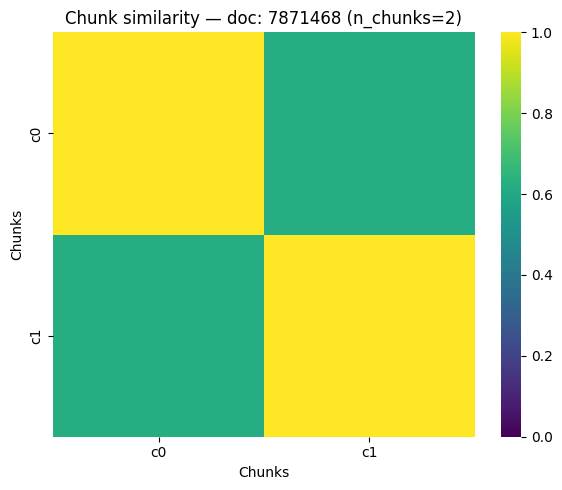

In [39]:
# if your chunks dataframe and embeddings are for tok_500:
chunks_df = all_chunks["tok_500"].reset_index(drop=True)   # ensure index aligns
embeddings = embeddings_store["tok_500"]                   # numpy array same order

# pick a doc that actually has >1 chunks — find a candidate:
multi = chunks_df.groupby("doc_id").size().sort_values(ascending=False)
multi.head(10)   # shows docs with most chunks

doc_to_plot = multi.index[0]   # longest doc
plot_doc_chunk_heatmap(chunks_df, embeddings, doc_to_plot, savepath="/kaggle/working/heatmap_doc.png")


In [40]:
def plot_sample_heatmap(chunks_df, embeddings, sample_size=100, seed=42, cmap="viridis", savepath=None):
    """
    plots similarity for a random sample of chunk embeddings across the corpus.
    sample_size: number of chunks to show (keep <=200 for readability)
    """
    n = len(chunks_df)
    sample_size = min(sample_size, n)
    rng = np.random.default_rng(seed)
    idx = rng.choice(n, size=sample_size, replace=False)
    embs = embeddings[idx]
    sim = cosine_similarity(embs)
    # label with doc and chunk id for quick inspection
    labels = [f"{chunks_df.loc[i,'doc_id']}:c{chunks_df.loc[i,'chunk_id']}" for i in idx]

    # hierarchical clustering to reorder similar chunks together
    Z = linkage(1 - sim, method="average")
    order = leaves_list(Z)
    sim = sim[np.ix_(order, order)]
    labels = [labels[i] for i in order]

    plt.figure(figsize=(10,8))
    sns.heatmap(sim, xticklabels=labels, yticklabels=labels, cmap=cmap, vmin=0, vmax=1)
    plt.title(f"Embedding similarity — sample {sample_size} chunks")
    plt.xticks(rotation=90, fontsize=7)
    plt.yticks(fontsize=7)
    plt.tight_layout()
    if savepath:
        plt.savefig(savepath, dpi=200, bbox_inches='tight')
    plt.show()


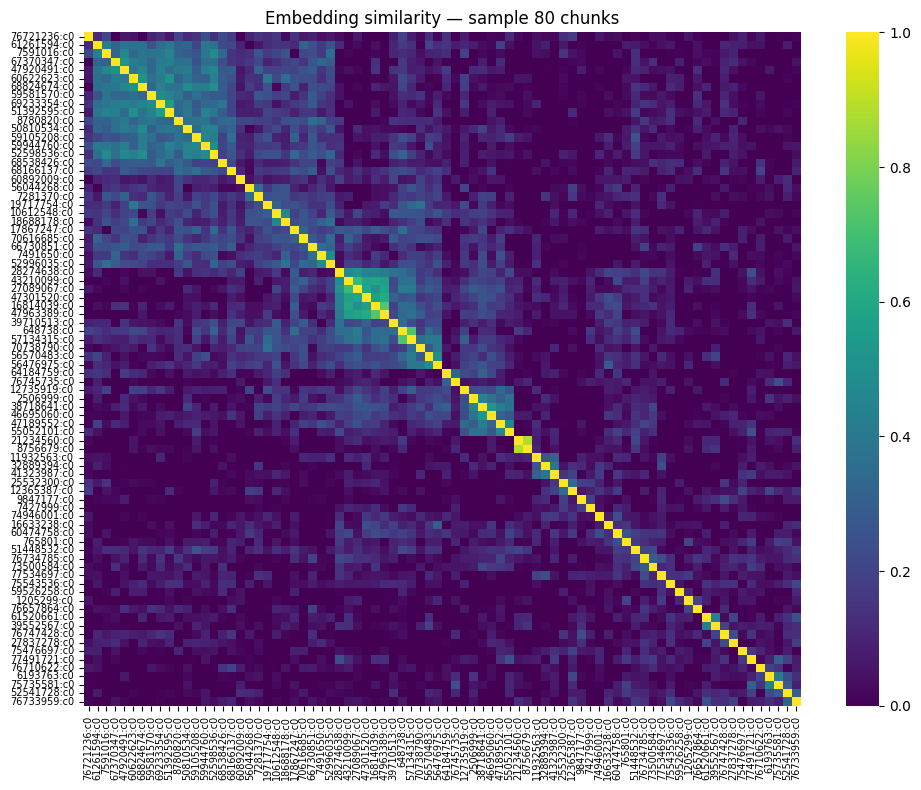

In [41]:
plot_sample_heatmap(chunks_df, embeddings_store["tok_500"], sample_size=80, savepath="/kaggle/working/sample_heatmap.png")
